In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import plotly.express as px

### Build Scoring System and Create Banckmark

In [2]:
# Step 1: Load Data
esg_file_path = './data/Technology Industry ESG data.csv'
esg_data = pd.read_csv(esg_file_path)
esg_data.head(1)

,Sub-sector,Company Name,Year,GHG Emissions (Scope 1) (tCO2e),GHG Emissions (Scope 2) (tCO2e),GHG Emissions (Scope 3) (tCO2e),Total Energy Consumption (MWhs),Total Water Consumption (ML),Total Waste Generated (t),Current Employees by Gender (Female %),...,Total Number of Employees,Average Training Hours per Employee,Fatalities,High-consequence injuries,Recordable injuries,Recordable work-related ill health cases,Board Independence (%),Women on the Board (%),Women in Management Team (%),Anti-Corruption Training for Employees (%)
0,Software and Services,Company_1,2020,439.330088,692.120861,934.282272,9795.219615,190.466071,10.890496,28.490657,...,649,20.900478,0,1,5,0,70.013601,14.053968,38.372039,84.106898


In [3]:
# Step 2: Data Preprocessing
# Drop non-numeric columns that are not needed for imputation
company_info = esg_data[['Sub-sector', 'Company Name', 'Year']]
esg_data_numeric = esg_data.drop(columns=['Sub-sector', 'Company Name', 'Year','Recordable work-related ill health cases', 
                                          'Average Training Hours per Employee', 'Total Energy Consumption (MWhs)',
                                          'Women on the Board (%)', 'Current Employees by Gender (Female %)', 
                                          'Women in Management Team (%)', 'Fatalities', 'Board Independence (%)'])

In [4]:
# Handle missing values
# (Implement techniques to handle missing data and ensure fair comparisons across companies.)
imputer = SimpleImputer(strategy='median')
esg_data_imputed = pd.DataFrame(imputer.fit_transform(esg_data_numeric), columns=esg_data_numeric.columns)

In [5]:
# Step 3: Standardize Data
scaler = StandardScaler()
esg_data_scaled = pd.DataFrame(scaler.fit_transform(esg_data_imputed), columns=esg_data_numeric.columns)

In [6]:
# Step 4: Apply KMeans Clustering
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(esg_data_scaled)
    wcss.append(kmeans.inertia_)

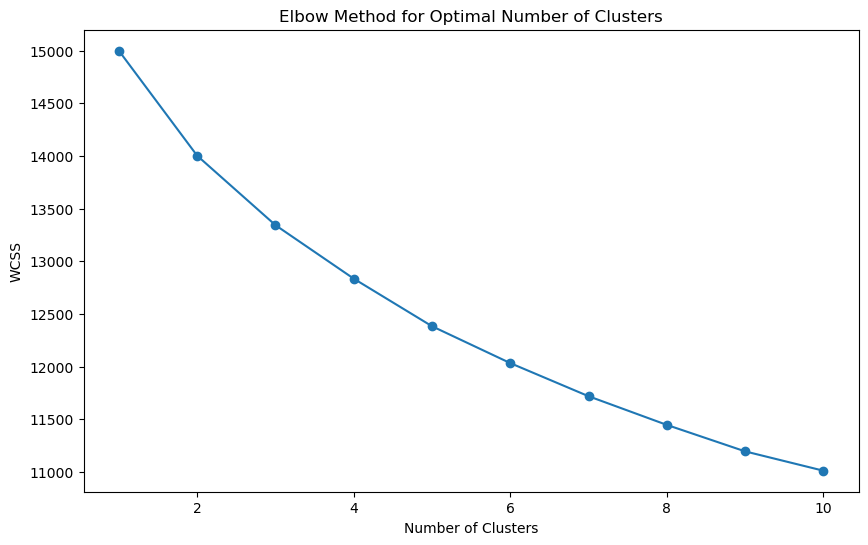

In [7]:
# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [8]:
# Step 5: Train KMeans Model with Optimal Number of Clusters
# Assuming the optimal number of clusters is 3 based on the elbow plot
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
# esg_data['Cluster'] = kmeans.fit_predict(esg_data_scaled)
cluster = kmeans.fit(esg_data_scaled)

**Save the Cluster Model**

In [14]:
import pickle

# save
with open('./cluster_model.pkl','wb') as f:
    pickle.dump(cluster,f)

In [15]:
with open('./cluster_model.pkl', 'rb') as f:
    k_cluster = pickle.load(f)

In [16]:
esg_data['Cluster'] = k_cluster.predict(esg_data_scaled)

In [17]:
# Step 6: Create General Industry Benchmark
# Since all companies are in the technology industry, create benchmark categories based on cluster assignments
esg_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=esg_data_numeric.columns)
esg_cluster_centers['Cluster'] = range(optimal_clusters)

In [19]:
# Categorize companies based on their cluster
def categorize_performance(cluster):
    if cluster == esg_cluster_centers['Cluster'].idxmax():
        return 'Good'
    elif cluster == esg_cluster_centers['Cluster'].idxmin():
        return 'Poor'
    else:
        return 'Average'

esg_data['Performance Category'] = esg_data['Cluster'].apply(categorize_performance)

print("General Technology Industry Benchmark Categories:")
esg_cluster_centers


General Technology Industry Benchmark Categories:


,GHG Emissions (Scope 1) (tCO2e),GHG Emissions (Scope 2) (tCO2e),GHG Emissions (Scope 3) (tCO2e),Total Water Consumption (ML),Total Waste Generated (t),New Hires and Turnover by Gender (Female %),Current Employees by Age Groups (Millennials %),Total Turnover (%),Total Number of Employees,High-consequence injuries,Recordable injuries,Anti-Corruption Training for Employees (%),Cluster
0,331.554256,624.912510,1068.360822,764.908021,61.690899,26.901131,51.215970,12.746879,585.675325,2.088312,5.363636,74.965275,0
1,307.520794,651.746084,1232.642001,331.836794,59.971585,31.556508,46.523585,12.265103,535.952941,1.072941,5.847059,77.684197,1
2,186.888965,406.071342,984.727385,537.059828,43.816217,31.081134,53.001832,12.610555,502.831818,1.327273,4.061364,71.839024,2


In [21]:
# Step 7: Create Scoring System
# Use a Linear Regression model to calculate an ESG performance score
X = esg_data_scaled
reg = LinearRegression()
reg.fit(X, esg_data['Cluster'])

LinearRegression()

**Save the model**

In [22]:
import pickle

# save
with open('./scoring_model.pkl','wb') as f:
    pickle.dump(reg,f)

In [ ]:
with open('./scoring_model.pkl', 'rb') as f:
    sc_reg = pickle.load(f)

# Predicted ESG performance score
esg_data['predicted_score'] = sc_reg.predict(X)

# Get feature importance (coefficients)
esg_feature_weights = pd.Series(sc_reg.coef_, index=esg_data_numeric.columns).sort_values(ascending=False)
print("Feature Weights for ESG Performance Scoring System:")
print(esg_feature_weights)

# Get intercept (b)
esg_intercept_b = reg.intercept_
print("Intercept (b):", esg_intercept_b)

Feature Weights for ESG Performance Scoring System:
New Hires and Turnover by Gender (Female %)        0.115291
Current Employees by Age Groups (Millennials %)    0.043742
Total Turnover (%)                                -0.011126
GHG Emissions (Scope 3) (tCO2e)                   -0.050072
Anti-Corruption Training for Employees (%)        -0.070935
Total Number of Employees                         -0.079174
Recordable injuries                               -0.118035
High-consequence injuries                         -0.182032
Total Waste Generated (t)                         -0.194137
Total Water Consumption (ML)                      -0.241883
GHG Emissions (Scope 2) (tCO2e)                   -0.260472
GHG Emissions (Scope 1) (tCO2e)                   -0.340581
dtype: float64
Intercept (b): 1.044


In [ ]:
# Predicted ESG performance score
esg_data['predicted_score'] = reg.predict(X)

# Get feature importance (coefficients)
esg_feature_weights = pd.Series(reg.coef_, index=esg_data_numeric.columns).sort_values(ascending=False)
print("Feature Weights for ESG Performance Scoring System:")
print(esg_feature_weights)

# Get intercept (b)
esg_intercept_b = reg.intercept_
print("Intercept (b):", esg_intercept_b)

Feature Weights for ESG Performance Scoring System:
New Hires and Turnover by Gender (Female %)        0.115291
Current Employees by Age Groups (Millennials %)    0.043742
Total Turnover (%)                                -0.011126
GHG Emissions (Scope 3) (tCO2e)                   -0.050072
Anti-Corruption Training for Employees (%)        -0.070935
Total Number of Employees                         -0.079174
Recordable injuries                               -0.118035
High-consequence injuries                         -0.182032
Total Waste Generated (t)                         -0.194137
Total Water Consumption (ML)                      -0.241883
GHG Emissions (Scope 2) (tCO2e)                   -0.260472
GHG Emissions (Scope 1) (tCO2e)                   -0.340581
dtype: float64
Intercept (b): 1.044


In [12]:
# R²
r2_score = reg.score(X, esg_data['Cluster'])
print(f'R² Score: {r2_score:.2f}')

R² Score: 0.60


In [13]:
esg_weights = dict(zip(esg_feature_weights.index, esg_feature_weights.values))
weights_df = pd.DataFrame([esg_weights])
weights_df

,New Hires and Turnover by Gender (Female %),Current Employees by Age Groups (Millennials %),Total Turnover (%),GHG Emissions (Scope 3) (tCO2e),Anti-Corruption Training for Employees (%),Total Number of Employees,Recordable injuries,High-consequence injuries,Total Waste Generated (t),Total Water Consumption (ML),GHG Emissions (Scope 2) (tCO2e),GHG Emissions (Scope 1) (tCO2e)
0,0.115291,0.043742,-0.011126,-0.050072,-0.070935,-0.079174,-0.118035,-0.182032,-0.194137,-0.241883,-0.260472,-0.340581


In [14]:
weights_df.to_csv("ESG Scoring Weights.csv", index = False)

In [15]:
esg_data.head(1)

,Sub-sector,Company Name,Year,GHG Emissions (Scope 1) (tCO2e),GHG Emissions (Scope 2) (tCO2e),GHG Emissions (Scope 3) (tCO2e),Total Energy Consumption (MWhs),Total Water Consumption (ML),Total Waste Generated (t),Current Employees by Gender (Female %),...,High-consequence injuries,Recordable injuries,Recordable work-related ill health cases,Board Independence (%),Women on the Board (%),Women in Management Team (%),Anti-Corruption Training for Employees (%),Cluster,Performance Category,predicted_score
0,Software and Services,Company_1,2020,439.330088,692.120861,934.282272,9795.219615,190.466071,10.890496,28.490657,...,1,5,0,70.013601,14.053968,38.372039,84.106898,1,Average,1.287343


In [16]:
esg_data.to_csv("ESG Scoring data.csv", index = False)

In [17]:
esg_data["predicted_score"].describe()

count    1250.000000
mean        1.044000
std         0.629875
min        -0.790077
25%         0.607696
50%         1.051628
75%         1.497920
max         2.644386
Name: predicted_score, dtype: float64

In [18]:
ESG_score_trend = esg_data.groupby('Year')['predicted_score'].mean().reset_index()
ESG_score_trend.rename(columns = {'predicted_score' : 'Industry mean'}, inplace = True)

In [19]:
soft_serve_esg = esg_data[esg_data['Sub-sector'] == 'Software and Services'].reset_index(drop=True)
tech_equip_esg = esg_data[esg_data['Sub-sector'] == 'Technology Hardware and Equipment'].reset_index(drop=True)
semi_esg = esg_data[esg_data['Sub-sector'] == 'Semiconductors and Semiconductor Equipment'].reset_index(drop=True)
info_tech_esg = esg_data[esg_data['Sub-sector'] == 'Information Technology'].reset_index(drop=True)
engin_esg = esg_data[esg_data['Sub-sector'] == 'Engineering Services'].reset_index(drop=True)

In [20]:
soft_serve_esg_trend = soft_serve_esg.groupby('Year')['predicted_score'].mean().reset_index()
soft_serve_esg_trend.rename(columns = {"predicted_score" : "Software and Services"}, inplace = True)

tech_equip_esg_trend = tech_equip_esg.groupby('Year')['predicted_score'].mean().reset_index()
tech_equip_esg_trend.rename(columns = {"predicted_score" : "Technology Hardware and Equipment"}, inplace = True)

semi_esg_trend = semi_esg.groupby('Year')['predicted_score'].mean().reset_index()
semi_esg_trend.rename(columns = {"predicted_score" : "Semiconductors and Semiconductor Equipment"}, inplace = True)

info_tech_esg_trend = info_tech_esg.groupby('Year')['predicted_score'].mean().reset_index()
info_tech_esg_trend.rename(columns = {"predicted_score" : "Information Technology"}, inplace = True)

engin_esg_trend = engin_esg.groupby('Year')['predicted_score'].mean().reset_index()
engin_esg_trend.rename(columns = {"predicted_score" : "Engineering Services"}, inplace = True)

In [21]:
sub_sectors_df = ESG_score_trend.merge(soft_serve_esg_trend, on='Year').merge(tech_equip_esg_trend, on='Year').merge(semi_esg_trend, on='Year').merge(info_tech_esg_trend, on='Year').merge(engin_esg_trend, on='Year')

In [22]:
esg_industry_plot_data = sub_sectors_df.melt(id_vars = ["Year"],
                           var_name = "sub-sectors", value_name = "predicted_score")

In [54]:
fig_esg_trend = px.line(esg_industry_plot_data, x = "Year", y = "predicted_score", color = "sub-sectors",
                      markers = True, 
                      title = "Environment score trend of the technology industry and sub-sectors")

fig_esg_trend.update_xaxes(dtick = 1)

fig_esg_trend.update_traces(
    hovertemplate = 'Year: %{x} <br> ESG Score: %{y} <extra></extra>', 
    marker = dict(size = 8)
)

fig_esg_trend.update_traces(selector = dict(name = 'Industry mean'),
                  line = dict(width = 4, color = "black"), 
                  marker = dict(size = 10, color = "black")) 

fig_esg_trend.show()

### Company Scoring

In [82]:
company_file_path = './data/Singtel_ESG_test.xlsx'
company_data = pd.read_excel(company_file_path)
company_data = company_data[company_data['Year'].between(2020, 2024)]


In [ ]:
company_info = company_data[['Company Name', 'Year']]
company_name = str(company_data.iloc[0]['Company Name'])

company_numeric = company_data.drop(columns=['Company Name', 'Year','Recordable work-related ill health cases', 
                                          'Average Training Hours per Employee', 'Total Energy Consumption (MWhs)',
                                          'Women on the Board (%)', 'Current Employees by Gender (Female %)', 
                                          'Women in Management Team (%)', 'Fatalities', 'Board Independence (%)'])

# Handle missing values(Implement techniques to handle missing data and ensure fair comparisons across
# companies.)
imputer = SimpleImputer(strategy='median')
company_imputed = pd.DataFrame(imputer.fit_transform(company_numeric), columns=company_numeric.columns)

# Standardize Data
scaler = StandardScaler()
company_scaled = pd.DataFrame(scaler.fit_transform(company_imputed), columns=company_numeric.columns)

In [ ]:
# Use KMeans to set Performance Category
# Use trained KMeans on input company
company_scaled_data = company_scaled.values  

company_clusters = kmeans.predict(company_scaled_data)
company_data['Cluster'] = company_clusters

# Set Performance Category based on clusters
def categorize_performance_by_cluster(cluster):
    if cluster == esg_cluster_centers['Cluster'].idxmax():
        return 'Good'
    elif cluster == esg_cluster_centers['Cluster'].idxmin():
        return 'Poor'
    else:
        return 'Average'

company_data['Performance Category'] = company_data['Cluster'].apply(categorize_performance_by_cluster)

# Scoring the input company
esg_weights = np.array(esg_feature_weights)

def calculate_score(features, weights, intercept):
    return np.dot(features, weights) + intercept

company_scores = company_scaled.apply(lambda row: calculate_score(row, esg_weights, esg_intercept_b), axis=1)
company_data['Calculated Score'] = company_scores


c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [49]:
company_score = company_data[['Year', 'Calculated Score']]
company_score.rename(columns = {'Calculated Score': company_name}, inplace = True)

C:\Users\LJM\AppData\Local\Temp\ipykernel_33192\3991916158.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
sub_sectors = {'Software and Services':['Captii','CSE Global','V2Y Corp','SinoCloud Grp'],
               'Technology Hardware and Equipment':['Addvalue Tech','Nanofilm','Venture'],
               'Semiconductors and Semiconductor Equipment':['AdvancedSystems','AEM SGD','Asia Vets','ASTI','UMS'],
               'Information Technology':['Audience'],
               'Engineering Services':['ST Engineering','Singtel','GSS Energy']}

In [74]:
# Loop through each company and check if target_value is in its list of industries using isin
for sub_sector in sub_sectors:
    if pd.Series(sub_sectors[sub_sector]).isin([company_name]).any():
        company_sub_sector = sub_sector

sub_sector_select = esg_industry_plot_data[esg_industry_plot_data["sub-sectors"] == company_sub_sector]
sub_sector_select = sub_sector_select.drop(columns = {'sub-sectors'})
sub_sector_select.rename(columns = {'predicted_score':company_sub_sector}, inplace = True)

In [75]:
compare_data = ESG_score_trend.merge(company_score, on = 'Year').merge(sub_sector_select, on = 'Year')
compare_data = compare_data.melt(id_vars = ["Year"],
                           var_name = "Type", value_name = "predicted_score")

In [78]:
fig_compare = px.line(compare_data, x = "Year", y = "predicted_score", color = "Type",
                      markers = True, 
                      title = "Comparison on ESG score trend")

fig_compare.update_traces(
    hovertemplate = 'Year: %{x} <br> ESG Score: %{y} <extra></extra>', 
    marker = dict(size = 8)
)

fig_compare.show()